# Chapter 8: Convolutional Neural Networks

New Skills in This Chapter:

• Applying filters on images and performing convolution operations

• Understanding kernel size, zero-padding, and strides

• Creating and training neural networks with convoluational layers

• Getting to know the max pooling layer

• Applying convolutional and max pooling layers in image classifications

***
*The pooling operation used in convolutional neural networks is a big mistake, and
the fact that it works so well is a disaster.*
***
--Geoffrey Hinton

***

In [1]:
import os

os.makedirs("files/ch08", exist_ok=True)

# 8.1 What Are Convolutional Neural Networks (CNNs)?


## 8.1.1 Our Running Example

Let’s say that the input data is the Tic Tac Toe game board. For simplicity let’s assume the board looks like the picture below:

<img src="https://gattonweb.uky.edu/faculty/lium/ml/ttthorizontal.PNG" />


Run the code in the cell below. 

In [2]:
import numpy as np

inputs = np.array([[1,1,1],
                   [0,0,0],
                   [0,0,0]]).astype('int32').reshape(-1,3,3,1)

## 8.1.2 A Horizontal Filter

In [3]:
# Create a horizontal filter
h_filter = np.array([[0,0,0], 
                   [1,1,1],
                   [0,0,0]]).astype('int32').reshape(3,3,1,1)

In [4]:
import tensorflow as tf

# Apply the filter on the game board
outputs=tf.nn.conv2d(inputs,h_filter,strides=1,padding="SAME")
# Convert output to numpy array and print it output
print(outputs.numpy().reshape(3,3))

[[2 3 2]
 [0 0 0]
 [0 0 0]]


In [5]:
# Define sqr() function to draw a square
def sqr(ax,x,y,size=1,linestyle="-",color="gray",linewidth=1):
    ax.plot([x,x+size],[y,y],linestyle=linestyle,
        color=color,linewidth=linewidth)
    ax.plot([x,x],[y+size,y],linestyle=linestyle,
        color=color,linewidth=linewidth)
    ax.plot([x+size,x+size],[y,y+size],linestyle=linestyle,
        color=color,linewidth=linewidth)
    ax.plot([x,x+size],[y+size,y+size],linestyle=linestyle,
        color=color,linewidth=linewidth)

next, a function to draw the padded board

In [6]:
# A function to draw the padded board
def padded_board(ax):
    # Draw solid squares    
    for i in range(3):
        for j in range(3):
            sqr(ax,-5+i,j,color="k",linewidth=2)
    # Draw dotted gray squares        
    for i in range(5):
        for j in range(5):
            sqr(ax,-6+i,-1+j,linestyle="dotted")
    # Put values inside squares        
    for x in range(5):
        for y in range(5):
            if 1<=x<=3 and y==3:
                ax.text(x-5.6,y-0.6,r"1",size=16,color="gray")
            else:
                ax.text(x-5.6,y-0.6,r"0",size=16,color="gray")

(-6.25, -0.75, -1.25, 4.25)

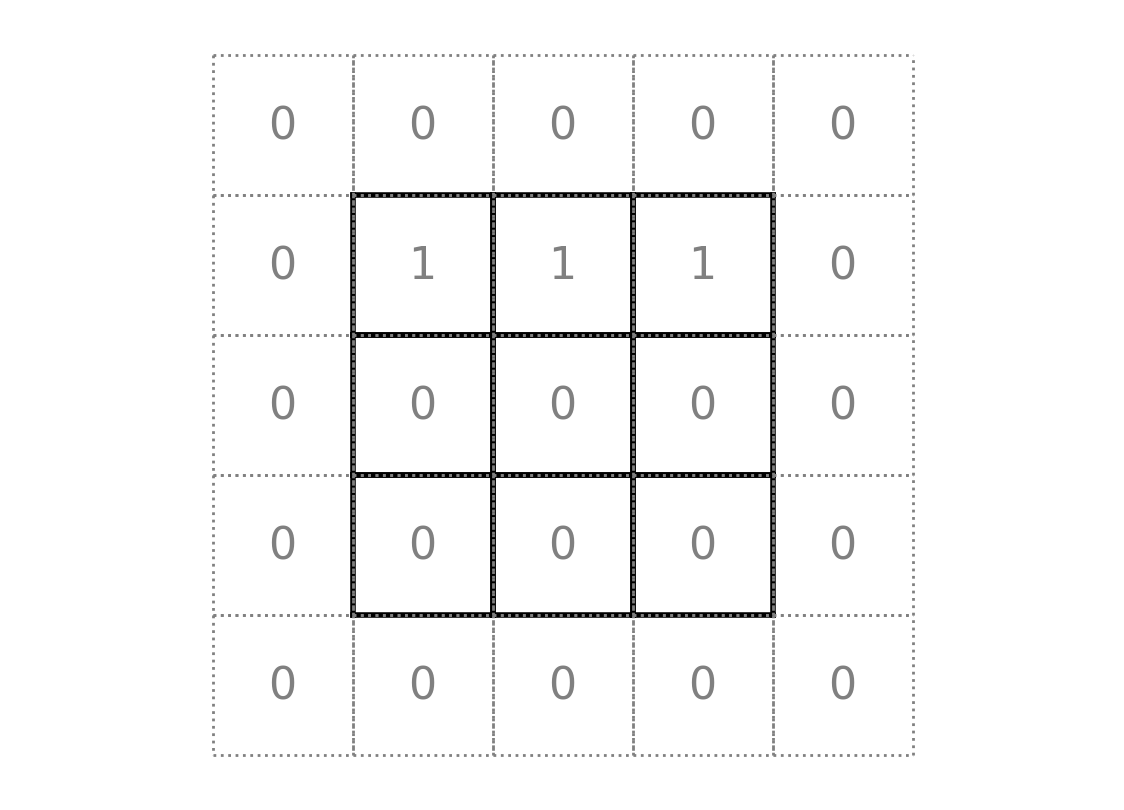

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7,5),dpi=200)
ax = fig.add_subplot(111)
# Draw the padded board
padded_board(ax)
ax.set_xlim(-6, -1)
ax.set_ylim(-1, 4)
# Keep the scale of x and y axis the same
plt.axis('equal')
plt.axis('off')

In [8]:
from matplotlib.patches import Rectangle

def scan(h,v):
    fig=plt.figure(figsize=(7,5),dpi=200)
    ax=fig.add_subplot(111)
    ax.set_xlim(-6,-1)
    ax.set_ylim(-1,4)
    plt.axis('equal')
    plt.axis('off')       
    padded_board(ax)
    # Draw the red scanner 
    for i in range(3):
        for j in range(3):
            sqr(ax,-6+i+h,1+j-v,color="r",linewidth=3) 
    # Save the picture
    plt.savefig(f"files/ch08/scan{h}{v}.png")
    plt.close(fig)
# Scan different areas
for v in range(3):
    for h in range(3):
        scan(h,v)       

In [9]:
import PIL
import imageio

frames=[] 
for v in range(3):
    for h in range(3):
        frame=PIL.Image.open(f"files/ch08/scan{h}{v}.png")  
        frame=np.asarray(frame)
        frames.append(frame) 
imageio.mimsave('files/ch08/filter.gif', frames, duration=1000) 

If you open the file filter.gif in your local folder, you'll see an animation as follows:
<img src="https://gattonweb.uky.edu/faculty/lium/ml/filter.gif"/>

# 8.2 Convolution Operation

## 8.2.1 Calculations in a convolation operation

In [10]:
# Create a horizontal filter
filter_array = np.array([[0,0,0],
                        [1,1,1],
                        [0,0,0]])
# Covered area
covered_area = np.array([[0,0,0],
                        [0,1,1],
                        [0,0,0]])
# Calculate the tensor dot
tensordot = np.tensordot(filter_array, covered_area)
       
print(f"the output at the top left corner is {tensordot}")

the output at the top left corner is 2


In [11]:
# Create a 5 by 5 matrix of zeros
padded_image=np.zeros((5,5))
# The board
image=np.array([[1,1,1],
                [0,0,0],
                [0,0,0]])
# Insert the board to the center of the padded board
padded_image[1:4,1:4]=image
print(f"the padded board has values \n{padded_image}")

the padded board has values 
[[0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [12]:
output=np.zeros((3,3))
for row in range(3):
    for col in range(3):
        area=padded_image[row:row+3,col:col+3]
        output[row,col]=np.tensordot(filter_array,area)    
print(f"the output is\n {output}")

the output is
 [[2. 3. 2.]
 [0. 0. 0.]
 [0. 0. 0.]]


## 8.2.2 Animate the Convolution Operations
We'll create an animation of the convoluation operations when the 3 by 3 filter is applied to the padded board. 

In [13]:
# add text to explain 
txt='Apply a 3 by 3 filter on a 3 by 3 image\
\nwith zero-padding\nstride=1'
def draw_text(ax,txt):
    ax.annotate(txt,xy=(0,0),xytext=(0.02,0.1), 
        textcoords='axes fraction', 
        bbox=dict(boxstyle="round",fc="0.9"), 
        fontsize=20) 

In [14]:
def draw_output_matrix(ax):
    # Draw the output matrix
    for i in range(3):
        for j in range(3):
            sqr(ax,2+i,j-3,linewidth=2,color="k")
            ax.text(2.4+i,-0.6-j,f"{output[j,i]}",\
                    size=16,color="gray")

In [15]:
def draw_filter(ax):
    # Draw filter on the side
    for i in range(3):
        for j in range(3):
            sqr(ax,3+i,j+1,color="r",linewidth=3)    
    ax.text(2,2.5,"filter=",size=16,color="r")
    # Put numbers in the filter        
    for x in range(3):
        for y in range(3):
            if y==1:
                ax.text(x+3.4,y+1.3,"1",size=16,color="gray")
            else:
                ax.text(x+3.4, y+1.3,"0",size=16,color="gray")

In [16]:
def apply_filter(ax,h,v):
    # Apply filter        
    for i in range(3):
        for j in range(3):
            sqr(ax,-6+i+h,1+j-v,color="r",linewidth=3)  

In [17]:
def slide(h,v):
    fig = plt.figure(figsize=(12,8), dpi=200)
    ax = fig.add_subplot(111)
    ax.set_xlim(-6, 6)
    ax.set_ylim(-4, 4)
    plt.axis("off")
    # Draw the padded board
    padded_board(ax) 
    # Put text in the figure 
    draw_text(ax,txt)
    # Draw the output matrx table
    draw_output_matrix(ax)
    # Draw the filter on the top right 
    draw_filter(ax)
    # Applies the filter on the board
    apply_filter(ax,h,v)
    # Save the first step in the position h,v
    plt.savefig(f"files/ch08/slide{h}{v}step1.png")
    # Draw two arrows
    ax.annotate('',xy=(2.3+h,-0.3-v),xytext=(-3+h,4-v), 
        arrowprops=dict(arrowstyle ='->',color='g',linewidth=1))        
    ax.annotate('',xy=(2.3+h,-0.3-v),xytext=(-6+h,1-v), 
        arrowprops=dict(arrowstyle='->',color='g',linewidth=1)) 
    # Save the second step in the position h,v
    plt.savefig(f"files/ch08/slide{h}{v}step2.png")
    # Highlight the value in the output table
    ax.text(2.4+h,-0.6-v,f"{output[v,h]}",size=16,color="r")
    # Save the third step in the position h,v
    plt.savefig(f"files/ch08/slide{h}{v}step3.png")
    plt.close(fig)

In [18]:
for v in range(3):
    for h in range(3):
        slide(h,v) 

In [19]:
import PIL
import imageio

frames=[] 
for v in range(3):
    for h in range(3):
        for step in range(1,4,1):
            file=f"files/ch08/slide{h}{v}step{step}.png"
            frame=PIL.Image.open(file)  
            frame=np.asarray(frame)
            frames.append(frame) 
imageio.mimsave('files/ch08/slidefilter.gif',frames,duration=500) 

You can view the animation below
<img src="https://gattonweb.uky.edu/faculty/lium/ml/slidefilter.gif"/>

## 8.2.3 Subplots 

In [20]:
pics=["00","10","20","01","21","02","12","22"]
plt.figure(figsize=(24,32),dpi=300)
for i in range(8):
    plt.subplot(4,2,i+1)
    file=f"files/ch08/slide{pics[i]}step3.png"
    frame=PIL.Image.open(file)
    plt.imshow(frame)
    plt.axis('off')
plt.subplots_adjust(bottom=0.001,right=0.999,top=0.999,
        left=0.001, hspace=-0.16,wspace=-0.02)
plt.savefig("files/ch08/slidestep3.png")

# 8.3 Stride and Padding

## 8.3.1 A Filter without Padding and A Stride of 2

In [21]:
# Create a 2 by 2 diagonal filter and a 6 by 6 image
d_filter = np.array([[1,0],
                   [0,1]]).astype('int32').reshape(2,2,1,1)
image = np.array([[1,0,0,1,1,0],
    			  [1,0,1,0,0,1],
    			  [0,0,0,1,1,0],
                  [0,1,1,0,1,0],
    			  [1,0,1,1,0,0],
    			  [0,1,0,0,1,0]]).astype('int32').reshape(-1,6,6,1)

In [22]:
# Apply the filter on the image
outputs=tf.nn.conv2d(image,d_filter,strides=2,
                     padding="VALID")
# Convert output to a numpy array and print the output
outputs=outputs.numpy().reshape(3,3).astype(float)
print(outputs)

[[1. 0. 2.]
 [1. 0. 1.]
 [2. 1. 0.]]


## 8.3.2 Animate the Diagonal Filter
next we animate the proces as well

In [23]:
image=image.reshape(6,6)
def stride(h,v):
    fig = plt.figure(figsize=(6,6),dpi=200)
    ax = fig.add_subplot(111)
    # Draw the 6 by 6 image 
    for i in range(6):
        for j in range(6):
            sqr(ax,-6+i,-2+j)
            ax.text(i-5.6,3.4-j,image[j,i],
                    size=16,color="gray")    
    # Draw the filter       
    for i in range(2):
        for j in range(2):
            sqr(ax,-6+i+2*h,2+j-2*v,color="b",linewidth=2)         
    ax.set_xlim(-6,0)
    ax.set_ylim(-2,4)
    plt.axis('equal')
    plt.axis('off')
    plt.savefig(f"files/ch08/stride{h}{v}.png")
    plt.close(fig)

In [24]:
for v in range(3):
    for h in range(3):
        stride(h,v)       

In [25]:
frames=[] 
for v in range(3):
    for h in range(3):
        file=f"files/ch08/stride{h}{v}.png"
        frame=PIL.Image.open(file)  
        frame=np.asarray(frame)
        frames.append(frame) 
imageio.mimsave('files/ch08/stride.gif',frames,duration=1000)      

If you open the file filter.gif in your local folder, you'll see an animation as follows:
<img src="https://gattonweb.uky.edu/faculty/lium/ml/stride.gif"/>

## 8.3.3 Animate the Diagonal Filter Convolution Operation
Next, we'll create an animation on how the output matrix is generated step by step. 

In [26]:
from utils.ch08util import stride_steps

for v in range(3):
    for h in range(3):
        stride_steps(h,v,image,outputs)  

In [27]:
frames=[] 
for v in range(3):
    for h in range(3):
        for step in range(1,4,1):
            file=f"files/ch08/stride{h}{v}step{step}.png"
            frame=PIL.Image.open(file)  
            frame=np.asarray(frame)
            frames.append(frame) 
imageio.mimsave('files/ch08/stridesteps.gif',frames,duration=500) 

You can view the animation below
<img src="https://gattonweb.uky.edu/faculty/lium/ml/stridesteps.gif"/>

## 8.3.4 Subplots for Strides


In [28]:
pics=["00","10","20","01","21","02","12","22"]
plt.figure(figsize=(24,32),dpi=300)
for i in range(8):
    plt.subplot(4,2,i+1)
    file=f"files/ch08/stride{pics[i]}step3.png"
    frame=PIL.Image.open(file)
    plt.imshow(frame)
    plt.axis('off')
plt.subplots_adjust(bottom=0.001,right=0.999,top=0.999,
        left=0.001, hspace=-0.16,wspace=-0.02)
plt.savefig("files/ch08/stridestep3.png")

# 8.4 Combine the Two Animations
Next, you'll put the two animations side by side in one single animation.

## 8.4.1 Combine the Animations

In [29]:
frames=[] 
for v in range(3):
    for h in range(3):
        for step in range(1,4,1):
            f1=f"files/ch08/slide{h}{v}step{step}.png"
            frame1=PIL.Image.open(f1)  
            frame1=np.asarray(frame1)
            f2=f"files/ch08/stride{h}{v}step{step}.png"
            frame2=PIL.Image.open(f2)  
            frame2=np.asarray(frame2)   
            frame=np.concatenate([frame1,frame2],axis=1)
            frames.append(frame) 
imageio.mimsave('files/ch08/slide_stride.gif',frames,duration=500) 

The resulting animation works as follows:<br>
<img src="https://gattonweb.uky.edu/faculty/lium/ml/slide_stride.gif" />

# 8.5 Max Pooling


In [30]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Create a diagonal filter and a 6 by 6 image
d_filter=np.array([[1,0],
                   [0,1]]).astype('int32').reshape(2,2,1,1)
image=np.array([[1,0,0,1,1,0],
               [1,0,1,0,0,1],
               [0,0,0,1,1,0],
               [0,1,1,0,1,0],
               [1,0,1,1,0,0],
               [0,1,0,0,1,0]]).astype('int32').reshape(-1,6,6,1)
# Apply the filter on the image
outputs=tf.nn.conv2d(image,d_filter,strides=2,
                     padding="VALID")
# Convert output to a numpy array and print the output
print("the output after the conv2d layer is \n",\
      outputs.numpy().reshape(3,3))
pooled_outputs=tf.nn.max_pool2d(input=outputs,\
             ksize=2,strides=1,padding="VALID")
print("the output after the max_pool2d layer is \n",\
      pooled_outputs.numpy().reshape(2,2))

the output after the conv2d layer is 
 [[1 0 2]
 [1 0 1]
 [2 1 0]]
the output after the max_pool2d layer is 
 [[1 2]
 [2 1]]


# 8.6 Binary Classifications with Convolutional Layers


In [31]:
import pickle

# Load the saved data from Chapter 7
X_train,X_test,y_train,y_test=pickle.load(
    open('files/ch07/train_test.p', 'rb'))
X_train = X_train.reshape(-1,32,32,1)
X_test = X_test.reshape(-1,32,32,1)

In [32]:
# Training the model
import tensorflow as tf
from tensorflow.keras import layers
tf.random.set_seed(0)
dnn = tf.keras.Sequential()
dnn.add(layers.Conv2D(filters=64, kernel_size=(3,3),\
      activation="relu", input_shape=(32,32,1)))
dnn.add(layers.MaxPooling2D(pool_size=(2,2)))
dnn.add(layers.Conv2D(filters=32, kernel_size=(3,3),
                      activation="relu"))
dnn.add(layers.MaxPooling2D(pool_size=(2,2)))
dnn.add(layers.Flatten())
dnn.add(layers.Dense(units=128, activation="relu"))
dnn.add(layers.Dropout(rate=0.2))
dnn.add(layers.Dense(1, activation='sigmoid'))
dnn.compile(optimizer="adam", 
            loss="binary_crossentropy",
            metrics=["accuracy"])
hist = dnn.fit(X_train, y_train, 
                  validation_data=(X_test, y_test),
                  verbose=0, epochs=125)
dnn.save('files/ch08/binary_conv.h5')

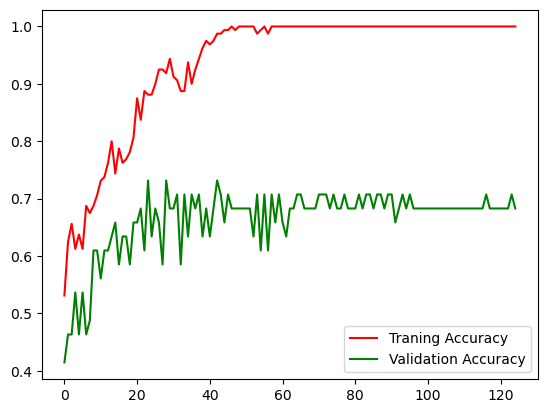

In [33]:
# View the training and validation loss 
plt.plot(hist.history["accuracy"],
         label='Traning Accuracy',color="r")
plt.plot(hist.history["val_accuracy"],
         label='Validation Accuracy',color="g")
plt.legend()
plt.show()

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
pred_model=dnn.predict(X_test)
# Convert values between 0 and 1 to Y or N 
pred_yn = np.where(pred_model > 0.5, 1, 0)

ma5=confusion_matrix(y_test,pred_yn)
print("the confusion matrix is\n", ma5) 

# Print out the accuracy score
accuracy=accuracy_score(y_test,pred_yn)
print(f"the accuracy of the prediction is {accuracy}") 

2/2 [==============================] - 0s 3ms/step
the confusion matrix is
 [[17  7]
 [ 6 11]]
the accuracy of the prediction is 0.6829268292682927


# 8.8 Exercises

In [35]:
# answer to question 8.3

import numpy as np

inputs = np.array([[1,1,1],
                   [0,0,0],
                   [0,0,0]]).astype('int32').reshape(-1,3,3,1)
# Create a vertical filter
v_filter = np.array([[0,1,0], 
                   [0,1,0],
                   [0,1,0]]).astype('int32').reshape(3,3,1,1)

import tensorflow as tf

# Apply the filter on the game board
v_outputs=tf.nn.conv2d(inputs,v_filter,strides=1,padding="SAME")
# Convert output to numpy array and print it output
print(v_outputs.numpy().reshape(3,3))

[[1 1 1]
 [1 1 1]
 [0 0 0]]


In [36]:
# answer to question 8.4
# Create a vertical filter
filter_array = np.array([[0,1,0], 
                       [0,1,0],
                       [0,1,0]])
# Covered area
covered_area = np.array([[0,0,0],
                        [0,1,1],
                        [0,0,0]])
# Calculate the tensor dot
tensordot = np.tensordot(filter_array, covered_area)
       
print(f"the output at the top left corner is {tensordot}")



# Create a 5 by 5 matrix of zeros
padded_image=np.zeros((5,5))
# The board
image=np.array([[1,1,1],
                [0,0,0],
                [0,0,0]])
# Insert the board to the center of the padded board
padded_image[1:4,1:4]=image
print(f"the padded board has values \n{padded_image}")



output=np.zeros((3,3))
for row in range(3):
    for col in range(3):
        area=padded_image[row:row+3,col:col+3]
        output[row,col]=np.tensordot(filter_array,area)    
print(f"the output is\n {output}")

the output at the top left corner is 1
the padded board has values 
[[0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
the output is
 [[1. 1. 1.]
 [1. 1. 1.]
 [0. 0. 0.]]


In [37]:
# answer to question 8.5
# Create a 2 by 2 diagonal filter and a 6 by 6 image
d_filter = np.array([[1,0],
                   [0,1]]).astype('int32').reshape(2,2,1,1)
image = np.array([[1,0,0,1,1,0],
    			  [1,0,1,0,0,1],
    			  [0,0,0,1,1,0],
                  [0,1,1,0,1,0],
    			  [1,0,1,1,0,0],
    			  [0,1,0,0,1,0]]).astype('int32').reshape(-1,6,6,1)



# Apply the filter on the image
outputs=tf.nn.conv2d(image,d_filter,strides=1,
                     padding="SAME")
# Convert output to a numpy array and print the output
outputs=outputs.numpy().reshape(6,6).astype(float)
print(outputs)

[[1. 1. 0. 1. 2. 0.]
 [1. 0. 2. 1. 0. 1.]
 [1. 1. 0. 2. 1. 0.]
 [0. 2. 2. 0. 1. 0.]
 [2. 0. 1. 2. 0. 0.]
 [0. 1. 0. 0. 1. 0.]]
